This notebook was made to explore the project and will have some preliminary results

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

$N^2 = -\frac{g}{\rho_{0}(z)}\frac{\partial \rho_{0}(z)}{\partial z}$

Assume $\rho_{0}$ = 1e3, $\frac{\partial \rho_{0}(z)}{\partial z}$ = 1e-1

Literature review of conditions for baroclinic tides:
$\frac{\sigma^2 - f^2}{N^2-\sigma^2}$~$\frac{dH}{dX}$

In [2]:
## define some constants
g = 10
ngrid =40
b0 = 400
L = 20e3
dx = L/(ngrid-1)
dz = b0/(ngrid-1)
omega =2*np.pi/(12.25*3600) ##frequency of the initial M2 barotropic tidal currents
k = - omega/np.sqrt(g*b0)## wavenumber in x dimension
N2 = 1e-3

In [3]:
##read in n2
#n2_file = np.loadtxt("n2winter.txt")

In [4]:
## define psi, psi_t, psi_c, H, x and z grid points
psi = np.zeros((ngrid,ngrid))
psi_t = np.zeros((ngrid,ngrid))
psi_c = np.zeros((ngrid,ngrid))
H = b0*np.ones((ngrid,ngrid))
x = np.arange(ngrid)
z= np.flipud(x)
x,z = np.meshgrid(x,z)

In [5]:
def bathy1(b0, ngrid):
    ## construct slope topography
    for i in np.arange(ngrid):
        H[i,:] = i*b0/(ngrid-1)   
    m = np.zeros_like(H)
    for i in np.arange(ngrid/2,ngrid,1):
        j = i-20
        m[i:, j] = 1
    ## mask the slope bathymetry
    Hm = np.ma.masked_array(H, m)
    #Hm[(ngrid-1)/2,0] = Hm[(ngrid-1)/2,1]
    #Hm[0,(ngrid-1)/2] = Hm[0,(ngrid-1)/2+1]
    Hm = np.flipud(Hm)

    return Hm

In [6]:
Hm = bathy1(b0,ngrid)

In [12]:
def bathy2(b0, ngrid):
    ## construct step topography
    topo = np.loadtxt("depth.txt")
    for i in np.arange(ngrid):
        H[i,:] =topo[i]
    m = np.zeros_like(H)
    for j in np.arange(ngrid/2):
        i = j+20
        m[i:, j] = 1
    ## mask the step bathymetry
    Hm = np.ma.masked_array(H, m)
    #Hm[(ngrid-1)/2,0] = Hm[(ngrid-1)/2,1]
    #Hm[0,(ngrid-1)/2] = Hm[0,(ngrid-1)/2+1]
    Hm = np.flipud(Hm)

    return Hm

In [6]:
## define slope of the topography
#x_slope = np.arange(ngrid/2)
#z_slope = np.flipud(np.arange(ngrid/2))
## define x,y_slope corner of the topography
#x_slope_corner = np.delete(x_slope, -1)
#z_slope_corner = z_slope+1
#z_slope_corner = np.delete(z_slope_corner, -1)
##append the corner points and slope points
#x_x = np.append(x_slope,x_slope_corner)
#z_z = np.append(z_slope,z_slope_corner)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


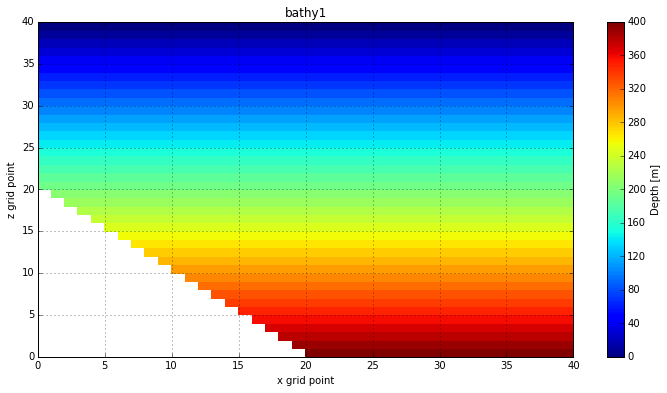

In [7]:
fig, ax =plt.subplots(1,1,figsize = (12,6))
plot=ax.pcolormesh(Hm,linewidth=0,rasterized=True, vmin = 0, vmax= 400)
cbar= plt.colorbar(plot)
cbar.set_label('Depth [m]')
ax.grid('on')
ax.set_xlim(0,40)
ax.set_xlabel('x grid point')
ax.set_ylabel('z grid point')
ax.set_ylim(0,40)
ax.set_title('bathy1')

In [8]:
def initial_conditions(psi):
    """Set the initial condition values when x=0.
    """
    psi[:,0] = 0
    ## the first x point:
    psi[-1+ngrid/2:,1] = (1/omega)*np.sqrt(g*b0)* np.sin(k*180*1/np.pi) * (b0+Hm[-1+ngrid/2:,-1])/b0
    ## the first z point (don't need it anymore)
    #psi[-2,:] = -(1/omega)*np.sqrt(g*b0)* np.sin(k*180*np.arange(0,40,1)/np.pi) * (b0+Hm[-2,0])/b0
    ## for slope boundary points:
    a= np.loadtxt('slope_index.txt')
    for i in np.arange(len(a)):
        psi[a[i,0],a[i,1]] = (1/omega)*np.sqrt(g*b0)* np.sin(k*180*i/np.pi) * (b0+Hm[a[i,0],-1])/b0
    return psi

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


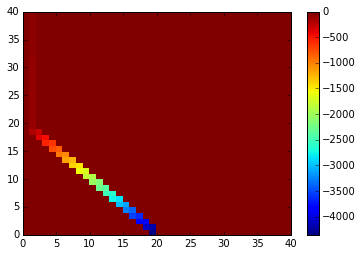

In [9]:
psi = initial_conditions(psi)
plt.pcolormesh(psi)
plt.colorbar()

In [10]:
def boundary_conditions(psi):
    """Set the boundary condition values.
    """
    ## three fixed boundary
    psi[-1,:] = -(1/omega)*np.sqrt(g*b0)* np.sin(k*180*np.arange(0,40,1)/np.pi) * (b0)/b0## surface wall(rigid lib)
    psi[-1+ngrid/2:,0] = 0 ## vertical wall
    psi[0,-1+ngrid/2:] = -(1/omega)*np.sqrt(g*b0)* np.sin(k*180*np.arange(-1+ngrid/2,40,1)/np.pi) * (b0+Hm[0,-1])/b0 ## bottom wall
    return psi

In [11]:
def leap_frog(psi_c):
    """Calculate the next x (or i) values using the leap-frog scheme.
    
    """
    #psi = initial_conditions(psi)
    ## This loop is for the whole domain
    a= np.loadtxt('slope_index.txt')
    for i in np.arange(1,ngrid-1):##(1,40) no 40
        for pz in np.arange(ngrid-2, 0,-1):##(38,1) no 1
            psi_c[pz, i+1] = 2*psi_c[pz, i] + (dx**2/N2)*(omega**2*(psi_c[pz-1,i]-2*psi_c[pz,i]\
            +psi_c[pz+1,i])/(dz**2)-(N2/g)*omega**2*(psi_c[pz-1,i]-psi_c[pz+1,i])/(2*dz)) - psi_c[pz, i-1]
            if [pz,i+1] in a:
                   psi_c[pz, i+1] = -(1/omega)*np.sqrt(g*b0)* np.sin(k*180*(i+1)/np.pi) * (b0+Hm[pz,-1])/b0
    
    return psi_c   

In [11]:
#mask = Hm.mask

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [12]:
#psi = np.ma.array(psi,mask =mask)

In [12]:
psi = initial_conditions(psi)
psi = boundary_conditions(psi)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


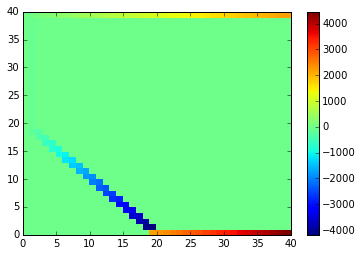

In [13]:
plt.pcolormesh(psi)
plt.colorbar()

In [14]:
## after leap frog
psi = leap_frog(psi)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


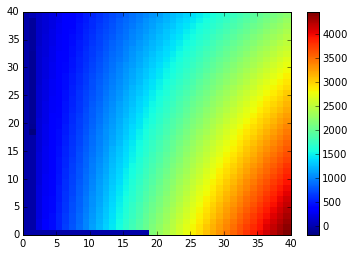

In [15]:
plt.pcolormesh(psi)
plt.colorbar()

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


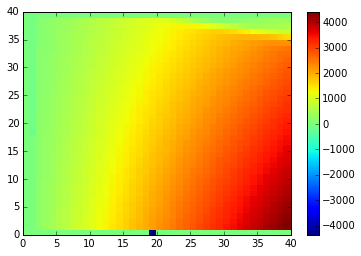

In [14]:
plt.pcolormesh(psi)
plt.colorbar()

In [17]:
psi_t = (1/omega)*np.sqrt(g*b0)* np.sin(k*180*np.arange(0,40,1)/np.pi) * (b0+Hm)/b0

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


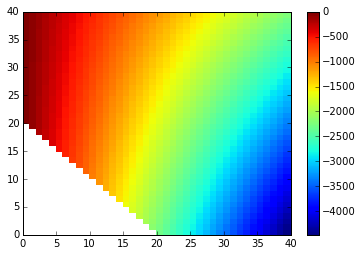

In [18]:
## barotropic inputs
plt.pcolormesh(psi_t)
plt.colorbar()